# Module de détection des pièces : Justifcation des choix de méthodes
Dans ce cahier, nous allons décomposer étape par étape notre pipeline de détection d'images. 
L'objectif est de visualiser l'impact de chaque transformation et de justifier nos choix de paramètres (tels que l'utilisation du seuillage adaptatif plutôt que la méthode classique d'Otsu).

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Fonction générique pour comparer plusieurs images côte à côte
def plot_comparison(images, titles, figsize=(18, 5)):
    """Affiche une liste d'images avec leurs titres correspondants."""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1: 
        axes = [axes]
        
    for ax, img, title in zip(axes, images, titles):
        # on passe en RGB pour Matplotlib
        if len(img.shape) == 3:
            img_disp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img_disp)
        else:
            # Sinon on l'affiche en nuances de gris
            ax.imshow(img, cmap='gray')
            
        ax.set_title(title, fontsize=14)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

target_width = 800 # taille cible de 800 px (idéale pour le compromis qualité-vitesse)

### 1. Prétraitement et Chargement de l'image

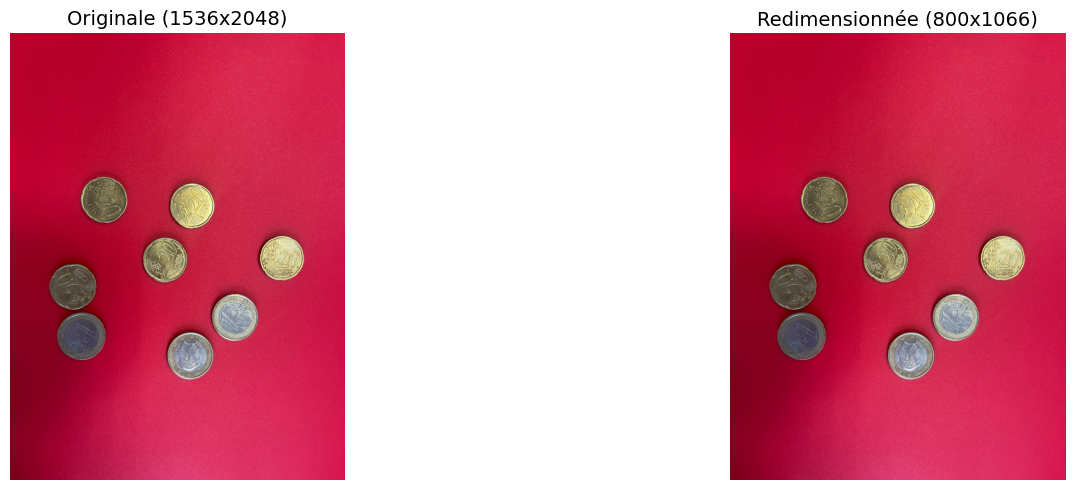

Analyse du fond : Coloré


In [ ]:
img_path = './data/gp3/3_3.jpg' # CETTE IMAGE EST IDÉALE POUR TESTER : elle a un fond coloré (nappe rouge) et une pièce dans l'ombre, ce qui est parfait pour notre analyse
img_original = cv2.imread(img_path)

if img_original is None:
    print(f"Erreur: Impossible de charger l'image {img_path}")
else:
    # 1. Redimensionnement (Preprocess)
    h, w = img_original.shape[:2]
    scale = target_width / w
    new_h = int(h * scale)
    img_resized = cv2.resize(img_original, (target_width, new_h), interpolation=cv2.INTER_AREA)

    plot_comparison([img_original, img_resized], 
                    [f'Originale ({w}x{h})', f'Redimensionnée ({target_width}x{new_h})'])

# (Issu de la classe CoinDetection, mais on le garde ici pour l'analyse du fond)
def analyse_background(img):
    """
    Samples the outer borders of the image to figure out background characteristics.
    """
    h, w = img.shape[:2]

    # Dynamic border thickness: 4% of the shortest side, bounded to a minimum of 5 pixels.
    b = max(int(min(h, w) * 0.04), 5)

    # Convert to HSV. It separates color intensity (Saturation) and brightness (Value)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Grab the pixel indices for the four edges (top, bottom, left, right).
    idx = np.concatenate([
        np.ravel_multi_index(np.mgrid[:b, :w], (h, w)).ravel(),
        np.ravel_multi_index(np.mgrid[h-b:h, :w], (h, w)).ravel(),
        np.ravel_multi_index(np.mgrid[:h, :b], (h, w)).ravel(),
        np.ravel_multi_index(np.mgrid[:h, w-b:w], (h, w)).ravel(),
    ])
    
    # Flatten the image to apply the 1D indices, extracting just the border pixels.
    flat = hsv.reshape(-1, 3)
    border = flat[idx]

    # We use median instead of mean. If a coin touches the edge, a mean would be skewed
    # Use median to avoid influence of outliers (like a coin touching the border)
    med_h, med_s, med_v = np.median(border, axis=0)

    is_coloured = med_s > 115  # Threshold to separate "colorful" from "drab/gray"
    
    return "Coloré" if is_coloured else "Neutre"

print("Analyse du fond :", analyse_background(img_resized))


### 2. Pourquoi utiliser le flou (Blur) et le CLAHE ?
Avant de créer notre masque binaire, nous passons l'image en niveaux de gris. 
- **CLAHE** permet d'équilibrer la lumière locale (récupère les pièces dans l'ombre).
- **Le flou gaussien (13x13)** est crucial : sans lui, l'algorithme de segmentation va essayer de détourer les étoiles et les visages *à l'intérieur* des pièces.

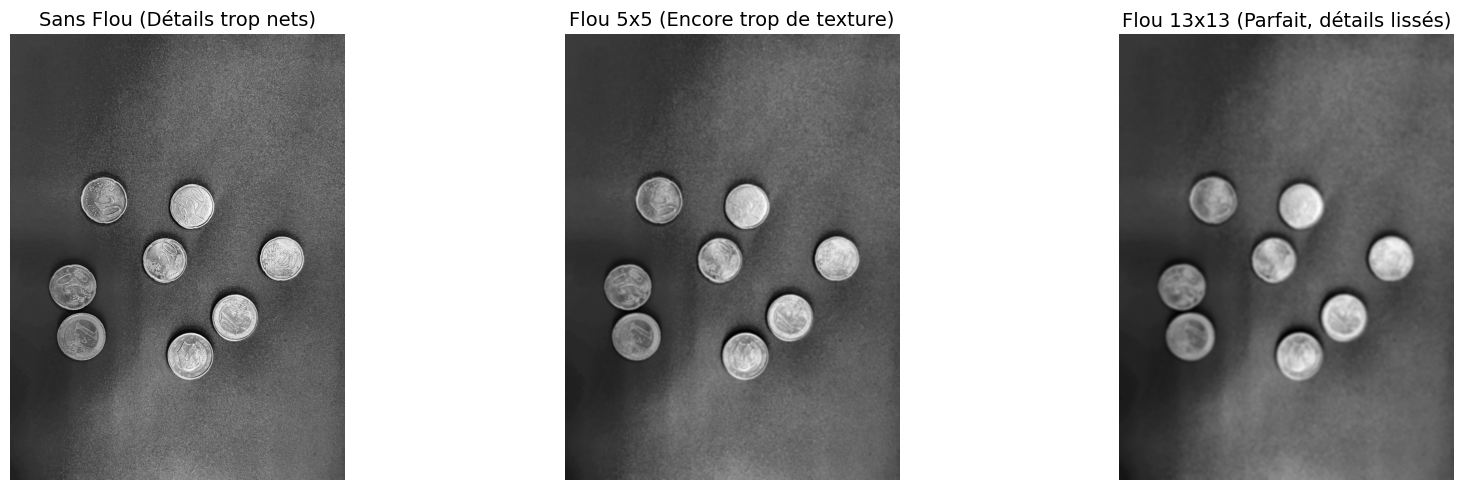

In [22]:
gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

# Application du CLAHE
clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# Comparaison des niveaux de flou
blur_none = enhanced
blur_small = cv2.GaussianBlur(enhanced, (7, 7), 0)
blur_heavy = cv2.GaussianBlur(enhanced, (13, 13), 3) # Notre choix !

plot_comparison(
    [blur_none, blur_small, blur_heavy], 
    ['Sans Flou (Détails trop nets)', 'Flou 5x5 (Encore trop de texture)', 'Flou 13x13 (Parfait, détails lissés)']
)

### 3. Segmentation : Otsu Global vs Adaptive Threshold
C'est ici que l'on justifie notre choix majeur. 
La méthode d'Otsu trouve un seuil unique pour toute l'image. 

Si l'image a une moitié à l'ombre et une moitié au soleil, Otsu échoue. 

L'**Adaptive Threshold** calcule un seuil dynamique pour chaque petite région de 21x21 pixels.

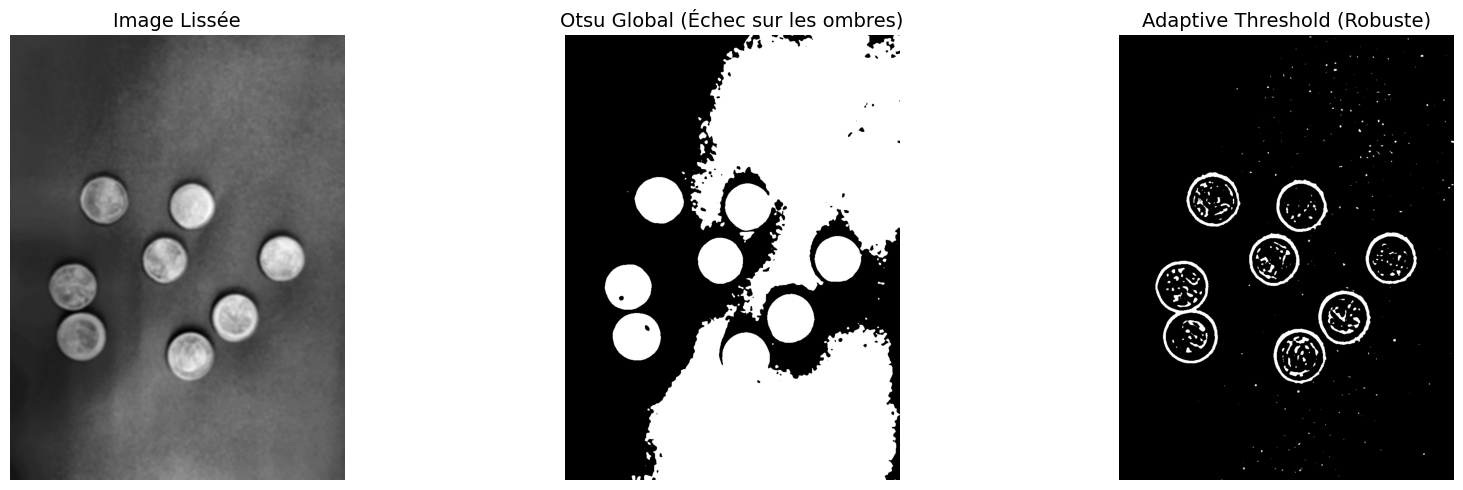

In [ ]:
# IL EST NÉCESSAIRE ICI DE PRENDRE UNE IMAGE AVEC UNE PIECE DANS L'OMBRE (Même si on a choisit une image dont le fond est défini comme "Coloré", ceci est juste pour montrer l'exemple sur les ombres)
# Test avec Otsu Global (Ce qu'on ne veut PAS utiliser pour les fonds neutres)
_, mask_otsu = cv2.threshold(blur_heavy, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

_, mask_otsu_inv = cv2.threshold(blur_heavy, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Test avec notre Adaptive Threshold
# on inverse (THRESH_BINARY_INV) si le fond est clair.
mask_adaptive = cv2.adaptiveThreshold(
    blur_heavy, 255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY_INV, #  Ici, notre image a un fond clair
    21, 4
)

plot_comparison(
    [blur_heavy, mask_otsu, mask_adaptive], 
    ['Image Lissée', 'Otsu Global (Échec sur les ombres)', 'Adaptive Threshold (Robuste)']
)

### 4. Nettoyage Morphologique
Le masque généré par l'Adaptive Threshold est souvent bruité (petits points noirs dans les pièces, ou poussières blanches dans le fond). Nous utilisons `MORPH_CLOSE` pour boucher les trous internes, et `MORPH_OPEN` pour effacer les poussières externes.

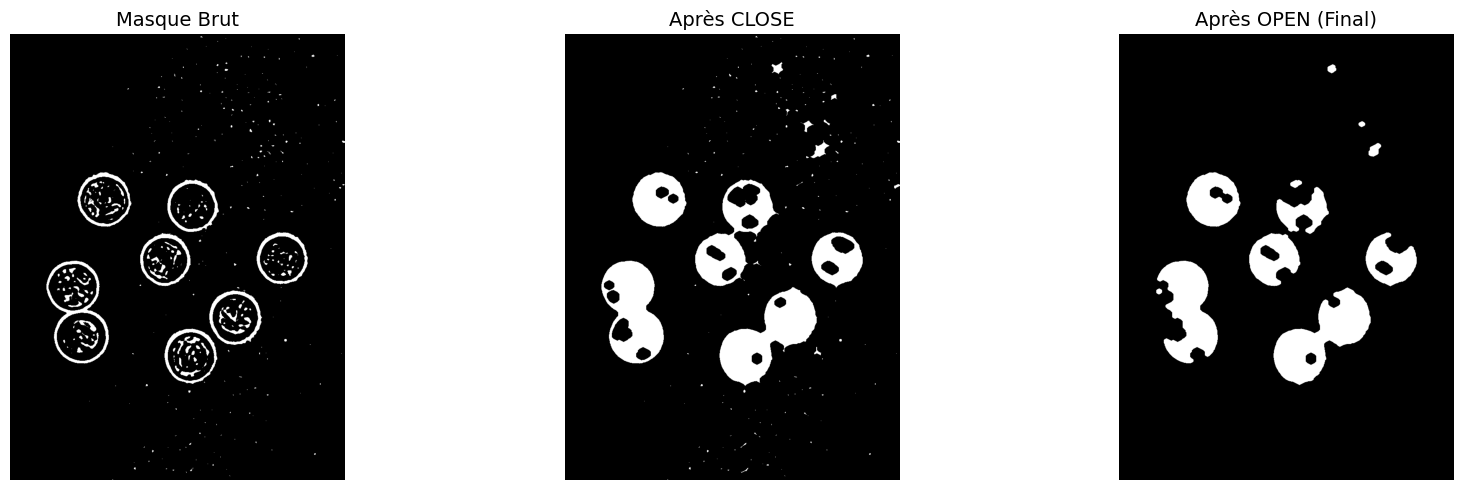

In [ ]:
# Nettoyage Morphologique
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
mask_closed = cv2.morphologyEx(mask_adaptive, cv2.MORPH_CLOSE, kernel, iterations=4)
mask_final = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel, iterations=2)

plot_comparison(
    [mask_adaptive, mask_closed, mask_final], 
    ['Masque Brut', 'Après CLOSE', 'Après OPEN (Final)']
)

### 5. Cas spécial : Les fonds très colorés (Stratégie de Saturation)
Si notre analyse détecte un fond rouge, bleu ou vert très vif, les méthodes basées sur les nuances de gris échouent (une pièce grise sur un fond bleu foncé ont la même "luminosité"). 
Nous utilisons alors le canal de **Saturation** (les pièces en métal n'ont aucune saturation, contrairement au fond).

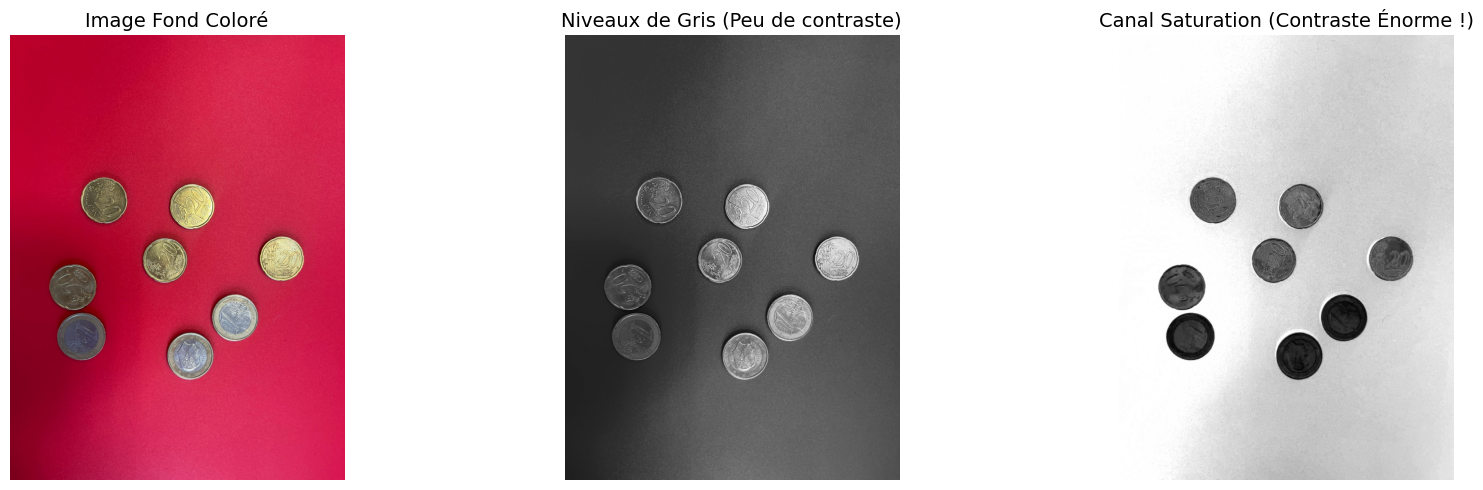

In [ ]:
# Tester sur une image avec un support chromatique
img_color_path = './data/gp3/3_3.jpg' 
img_color = cv2.imread(img_color_path)

img_color = cv2.resize(img_color, (target_width, int(img_color.shape[0] * (target_width/img_color.shape[1]))))

# Extraction du canal Gris vs Saturation
gray_fail = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)
saturation = hsv[:, :, 1] # Le métal sera très noir (0), le fond très blanc (255)

plot_comparison(
    [img_color, gray_fail, saturation], 
    ['Image Fond Coloré', 'Niveaux de Gris (Peu de contraste)', 'Canal Saturation (Contraste Énorme !)']
)

# Étape 5 : Les Algorithmes de Détection
Nous allons maintenant tester nos trois algorithmes : **Hough, Watershed et Contours**.
Pour bien voir leur utilité, chargeons une image où les pièces sont proches ou se touchent (ce qui fait généralement échouer les algorithmes simples).

*Note : Nous ajoutons une petite fonction utilitaire pour dessiner nos résultats plus facilement.*

In [26]:
# Fonction utilitaire pour dessiner les cercles sur une image
def draw_detected_coins(img, coins, color=(0, 255, 0), thickness=2):
    vis = img.copy()
    # Si c'est une image en niveaux de gris, on la passe en couleur pour voir nos dessins
    if len(vis.shape) == 2:
        vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2RGB)
        
    for c in coins:
        cv2.circle(vis, (c['x'], c['y']), c['r'], color, thickness)
        cv2.circle(vis, (c['x'], c['y']), 2, (255, 0, 0), -1) # Point central
    return vis

In [27]:
# REDEFINTION DES PRECEDENTES ETAPES POUR UNE NOUVELLE IMAGE (Tester avec plusieurs images pour valider la robustesse de notre méthode)
img_det_path = './data/gp5/12.jpg'
img_det_original = cv2.imread(img_det_path)

h, w = img_det_original.shape[:2]
img_det = cv2.resize(img_det_original, (target_width, int(h * (target_width/w))), interpolation=cv2.INTER_AREA)
gray_det = cv2.cvtColor(img_det, cv2.COLOR_BGR2GRAY)

# Génération du masque binaire
clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
blur_det = cv2.GaussianBlur(clahe.apply(gray_det), (13, 13), 3)

# On calcule vite fait si l'image est globalement claire ou sombre
is_light_bg = np.mean(gray_det) > 115
# Si c'est clair, on INVERSE (THRESH_BINARY_INV) pour que les pièces deviennent blanches !
thresh_type = cv2.THRESH_BINARY_INV if is_light_bg else cv2.THRESH_BINARY

binary_det = cv2.adaptiveThreshold( 
    blur_det, 255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresh_type, 
    21, 4
)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
binary_det = cv2.morphologyEx(binary_det, cv2.MORPH_CLOSE, kernel, iterations=4)
binary_det = cv2.morphologyEx(binary_det, cv2.MORPH_OPEN, kernel, iterations=2)
# FIN DE REDEFINTION DES PRECEDENTES ETAPES

### Méthode 1 : La Transformée de Hough (Détection géométrique)
Hough cherche la géométrie parfaite des cercles dans l'image.
Il utilise les variations de contraste (gradients) pour repérer les bords extérieurs. Pour éviter qu'il ne se perde dans les détails internes des pièces (les visages ou les étoiles), on applique un flou massif (15x15) au préalable. Cela détruit les gravures complexes et ne laisse que la silhouette ronde globale de la pièce.

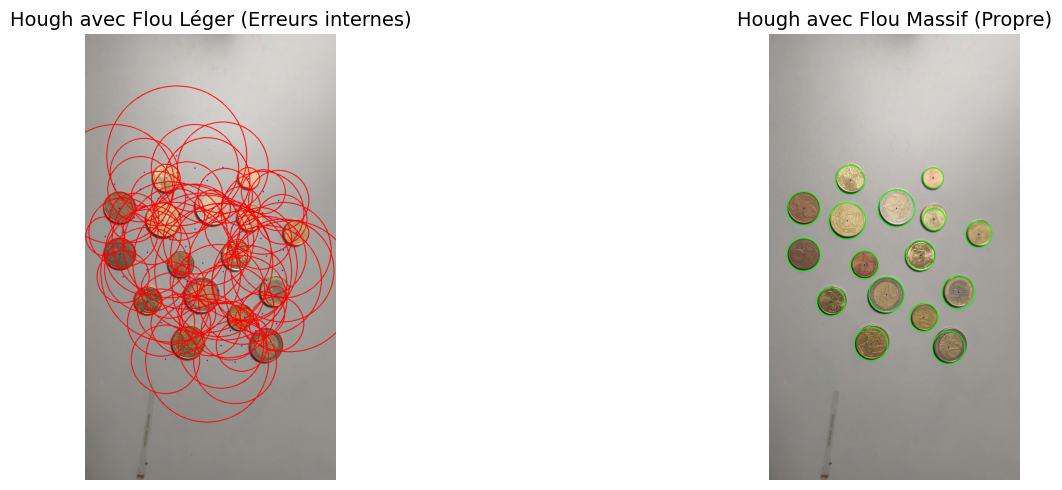

In [ ]:
# Image avec un léger flou (Ce qu'il ne faut pas faire)
gray_light_blur = cv2.GaussianBlur(clahe.apply(gray_det), (5, 5), 0)

# Image avec notre flou massif (Ce que fait notre code)
gray_heavy_blur = cv2.GaussianBlur(clahe.apply(gray_det), (15, 15), 3)

# Paramètres de base pour Hough
min_r, max_r = 22, int(min(img_det.shape[:2]) * 0.28)
min_dist = max(int(min_r * 2.1), 55)

# Test sur le flou léger
circles_light = cv2.HoughCircles(gray_light_blur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=min_dist, param1=100, param2=45, minRadius=min_r, maxRadius=max_r)
coins_light = [{'x': int(c[0]), 'y': int(c[1]), 'r': int(c[2])} for c in np.round(circles_light[0])] if circles_light is not None else []

# Test sur le flou lourd
circles_heavy = cv2.HoughCircles(gray_heavy_blur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=min_dist, param1=100, param2=45, minRadius=min_r, maxRadius=max_r)
coins_heavy = [{'x': int(c[0]), 'y': int(c[1]), 'r': int(c[2])} for c in np.round(circles_heavy[0])] if circles_heavy is not None else []

plot_comparison(
    [draw_detected_coins(img_det, coins_light, (0,0,255)), draw_detected_coins(img_det, coins_heavy, (0,255,0))], 
    ['Hough avec Flou Léger (Erreurs internes)', 'Hough avec Flou Massif (Propre)']
)

### Méthode 2 : L'Algorithme de Watershed (Ligne de partage des eaux)
**Watershed résout le problème des pièces qui se touchent.**

Il calcule la distance entre chaque pixel blanc et le fond noir. Le centre de la pièce devient un "pic" d'intensité. On coupe ces pics, et on inonde l'image à partir de ces centres pour créer des barrages entre les pièces.

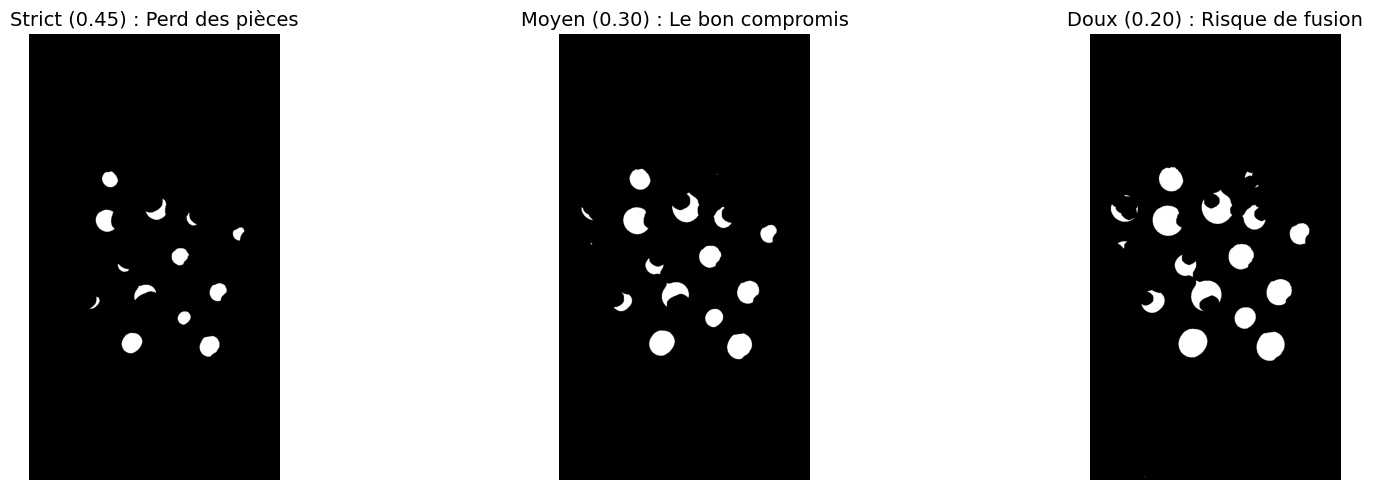

In [ ]:
# Transformée de distance (Topographie)
dist = cv2.distanceTransform(binary_det, cv2.DIST_L2, 5)
dist_norm = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)

# On teste 3 seuils différents pour trouver le réglage parfait
# L'objectif est de garder les petites pièces sans que les centres fusionnent.
thresh_strict  = 0.45 * dist_norm.max() # L'ancien réglage (trop dur)
thresh_medium  = 0.30 * dist_norm.max() # Réglage intermédiaire
thresh_lenient = 0.20 * dist_norm.max() # Réglage très permissif

_, sure_fg_strict  = cv2.threshold(dist_norm, thresh_strict, 1.0, 0)
_, sure_fg_medium  = cv2.threshold(dist_norm, thresh_medium, 1.0, 0)
_, sure_fg_lenient = cv2.threshold(dist_norm, thresh_lenient, 1.0, 0)

# On affiche les 3 résultats côte à côte pour comparer
plot_comparison(
    [sure_fg_strict, sure_fg_medium, sure_fg_lenient], 
    [f'Strict (0.45) : Perd des pièces', 
     f'Moyen (0.30) : Le bon compromis', 
     f'Doux (0.20) : Risque de fusion']
)

### Méthode 3 : L'Analyse des Contours (Filtres géométriques)
Cette méthode prend le masque binaire et en extrait les bordures externes. 
Plutôt que de chercher une forme parfaite comme Hough, elle calcule des métriques mathématiques sur ces formes : la **circularité** (est-ce que ça ressemble à un cercle ?) et la **solidité** (est-ce que la forme est pleine, et non pas un croissant ?). C'est très efficace pour les pièces bien détourées.

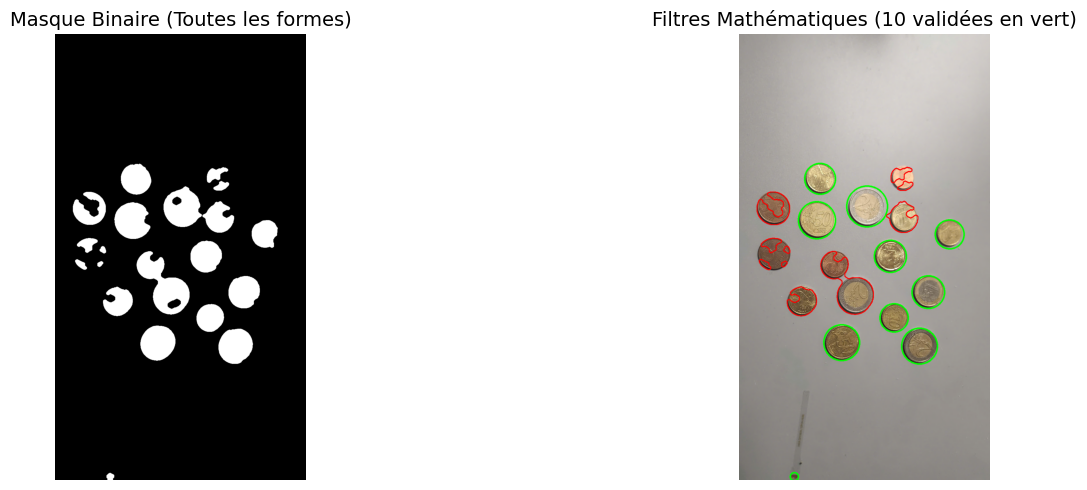

In [ ]:
# Copie de l'image pour l'affichage visuel
img_filtres = img_det.copy()

# Extraction de TOUS les contours trouvés dans le masque binaire
contours, _ = cv2.findContours(binary_det, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

pieces_validees = 0

for cnt in contours:
    area = cv2.contourArea(cnt)
    perim = cv2.arcLength(cnt, True)

    if perim == 0:
        continue
        
    # Calcul de la Circularité
    circ = 4 * np.pi * area / (perim ** 2)
    
    # Calcul de la Solidité
    (cx, cy), r = cv2.minEnclosingCircle(cnt)
    solidite = area / (np.pi * r**2)
    
    # Application de tes règles strictes
    if circ > 0.72 and solidite > 0.75:
        # Ça passe les filtres : on dessine le cercle en VERT
        cv2.circle(img_filtres, (int(cx), int(cy)), int(r), (0, 255, 0), 3)
        pieces_validees += 1
    else:
        # C'est rejeté (ex: bruit de fond, mauvaise ombre) : on dessine le contour en ROUGE
        cv2.drawContours(img_filtres, [cnt], -1, (0, 0, 255), 2)

# Affichage du résultat pour le jury
plot_comparison(
    [binary_det, img_filtres], 
    ['Masque Binaire (Toutes les formes)', f'Filtres Mathématiques ({pieces_validees} validées en vert)']
)

# 6. La Validation (Le "Videur")
Même avec les meilleurs paramètres, nos algorithmes (Hough, Contours) vont inévitablement détecter de faux cercles (un motif rond sur la table, une tache, etc.). 
Pour éviter ça, nous avons créé la méthode `_validate_fast` qui fait passer deux tests physiques à chaque cercle candidat.

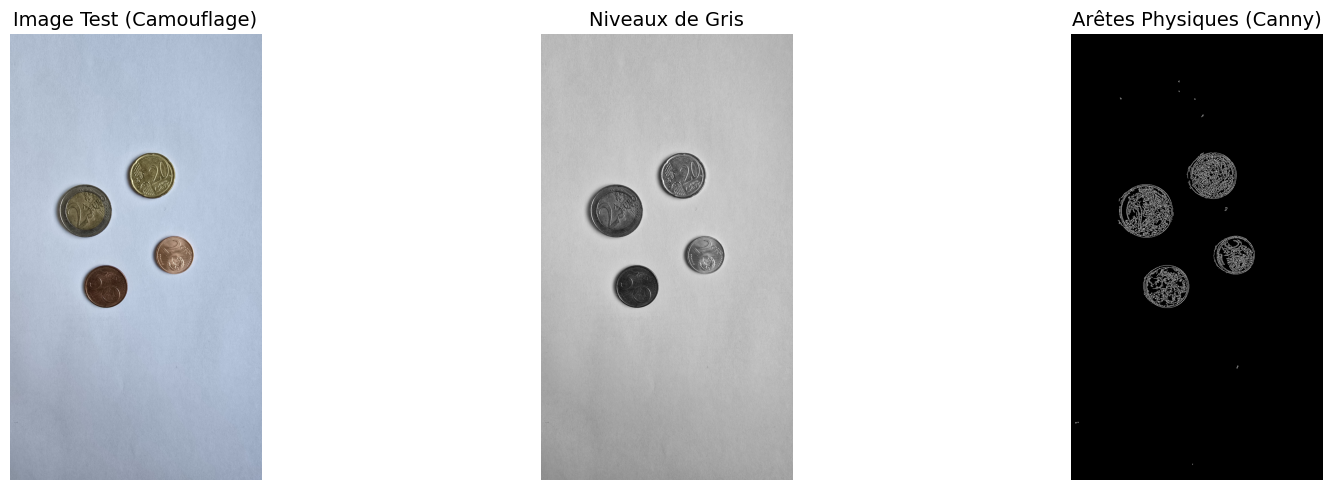

In [ ]:
img_val_path = './data/gp4/2.jpg' 
img_val_original = cv2.imread(img_val_path)

# On refait le preprocessing rapide pour cette nouvelle image
h, w = img_val_original.shape[:2]
scale = target_width / w
img_val = cv2.resize(img_val_original, (target_width, int(h * scale)), interpolation=cv2.INTER_AREA)

# Pré-calcul pour la validation : Niveaux de gris et Canny
gray_val = cv2.cvtColor(img_val, cv2.COLOR_BGR2GRAY)

# Seuils 50/150 standards pour détecter les arêtes métalliques
edges_val = cv2.Canny(gray_val, 50, 150)

plot_comparison(
    [img_val, gray_val, edges_val], 
    ['Image Test (Camouflage)', 'Niveaux de Gris', 'Arêtes Physiques (Canny)']
)

### Le Test 1 : Le "Donut Test" (Contraste de Couleur)
Ce test vérifie si la zone **à l'intérieur** du cercle a une couleur différente de la zone **immédiatement à l'extérieur**.
- **Masque interne :** On prend 70% du rayon pour ne lire que le métal (et ignorer l'ombre du bord).
- **Masque externe (Donut) :** On prend une couronne de 100% à 120% du rayon pour lire le fond immédiat.
Si la différence moyenne de gris entre les deux est > 15, on valide la pièce.

**Pré-calcul pour la performance :**
Au lieu de recalculer les filtres pour chaque candidat (ce qui prendrait des minutes), nous calculons une seule fois la carte des contours nets (Canny Edge) sur toute l'image.

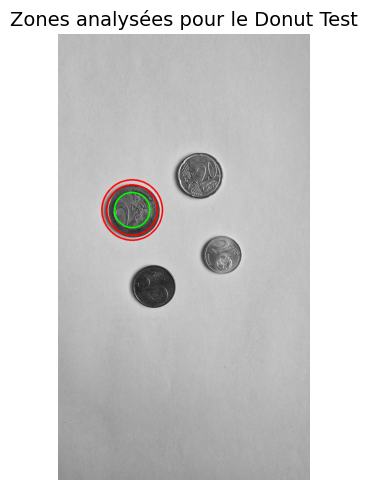

Couleur moyenne interne : 96.2
Couleur moyenne externe : 152.0
Différence de contraste local : 55.80
Validation Donut réussie (> 15) ? OUI


In [ ]:
h_val, w_val = gray_val.shape[:2]

# On simule un cercle candidat (remplacer x, y par les coordonnées d'une pièce, et tester sur un endroit où il n'y a pas de pièce pour valider que le test est robuste au bruit)
x, y, r = 235, 560, 80


# On crée une copie de l'image (en couleur, pour pouvoir dessiner en vert/rouge)
if len(gray_val.shape) == 2:
    img_visu = cv2.cvtColor(gray_val, cv2.COLOR_GRAY2BGR)
else:
    img_visu = gray_val.copy()

# 1. Masque interne (70% du rayon)
mask_in = np.zeros((h_val, w_val), dtype=np.uint8)
cv2.circle(mask_in, (x, y), int(r * 0.7), 255, -1)

# 2. Masque externe (Couronne / Donut)
mask_out = np.zeros((h_val, w_val), dtype=np.uint8)
cv2.circle(mask_out, (x, y), int(r * 1.2), 255, -1)
cv2.circle(mask_out, (x, y), r, 0, -1) # On évide le centre

# On dessine la limite de la zone INTERNE (la pièce analysée) en VERT, épaisseur 3
cv2.circle(img_visu, (x, y), int(r * 0.7), (0, 255, 0), 3)

# 3. On dessine les limites de la zone EXTERNE (le donut/fond) en ROUGE, épaisseur 3
cv2.circle(img_visu, (x, y), r, (0, 0, 255), 3) # Bordure intérieure du donut
cv2.circle(img_visu, (x, y), int(r * 1.2), (0, 0, 255), 3) # Bordure extérieure du donut

# On affiche l'image avec les zones superposées
plot_comparison(
    [img_visu], 
    ['Zones analysées pour le Donut Test']
)
# -----------------------------------------------

# Simulation du calcul OpenCV (inchangé)
mean_in = cv2.mean(gray_val, mask=mask_in)[0]
mean_out = cv2.mean(gray_val, mask=mask_out)[0]
diff_color = abs(mean_in - mean_out)

print(f"Couleur moyenne interne : {mean_in:.1f}")
print(f"Couleur moyenne externe : {mean_out:.1f}")
print(f"Différence de contraste local : {diff_color:.2f}")
print(f"Validation Donut réussie (> 15) ? {'OUI' if diff_color > 15 else 'NON (Passer au test 2)'}")

### Le Test 2 : Le Scénario du Camouflage (Canny Edge Score)
Que se passe-t-il si une pièce argentée est posée sur une table grise ? La différence de couleur (Donut Test) sera proche de zéro. La pièce serait faussement rejetée.

**La solution :** Une pièce de monnaie a une épaisseur physique (3D). Elle crée donc une micro-ombre sur son contour. On dessine le périmètre exact du cercle candidat (épaisseur 2 pixels) et on regarde s'il superpose des traits blancs sur notre carte `Canny`. Si le score est > 30, c'est un objet en relief, on valide !

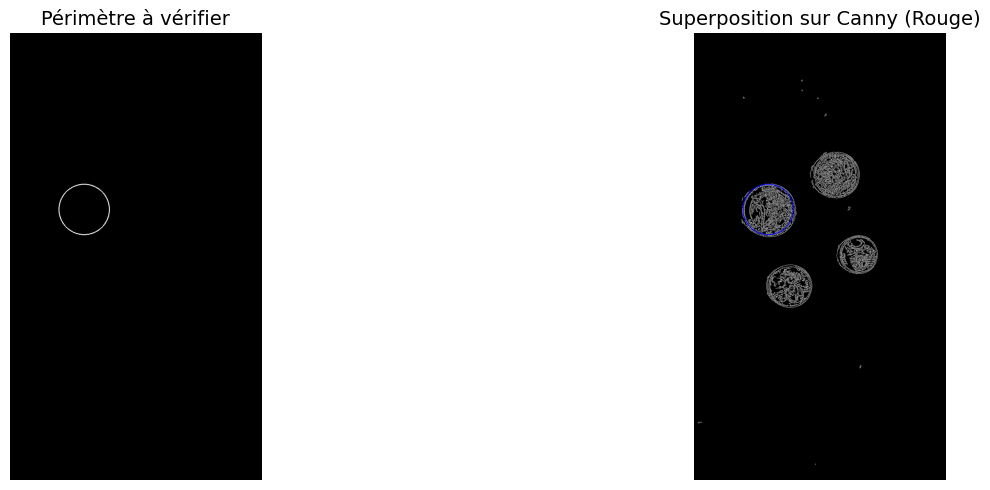

Score Canny Edge (Camouflage Test) : 77.99
Validation Edge réussie (> 30) ? OUI


In [33]:
# Masque du périmètre (épaisseur 2)
mask_edge = np.zeros((h_val, w_val), dtype=np.uint8)
cv2.circle(mask_edge, (x, y), r, 255, 2)

# On superpose visuellement notre masque de recherche sur la carte Canny
# (En rouge : le cercle géométrique qu'on cherche à valider)
canny_rgb = cv2.cvtColor(edges_val, cv2.COLOR_GRAY2RGB)
canny_rgb[mask_edge == 255] = [255, 0, 0] 

plot_comparison(
    [mask_edge, canny_rgb], 
    ['Périmètre à vérifier', 'Superposition sur Canny (Rouge)']
)

# Simulation du calcul : on fait la moyenne des pixels blancs de Canny qui tombent sous notre masque rouge
edge_score = cv2.mean(edges_val, mask=mask_edge)[0]

print(f"Score Canny Edge (Camouflage Test) : {edge_score:.2f}")
print(f"Validation Edge réussie (> 30) ? {'OUI' if edge_score > 30 else 'NON (C\'est une fausse détection)'}")